In [3]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY', '0663ba57c9234956a28fd247fda5d54c')

In [6]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [7]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [8]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

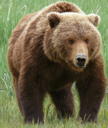

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [12]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [13]:
fns = get_image_files(path)
fns

(#442) [Path('bears/black/00000000.JPG'),Path('bears/black/00000001.jpg'),Path('bears/black/00000002.jpg'),Path('bears/black/00000003.jpg'),Path('bears/black/00000004.jpg'),Path('bears/black/00000005.jpg'),Path('bears/black/00000006.jpg'),Path('bears/black/00000007.jpg'),Path('bears/black/00000008.jpg'),Path('bears/black/00000009.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#0) []

In [15]:
failed.map(Path.unlink);

In [16]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bears.dataloaders(path)

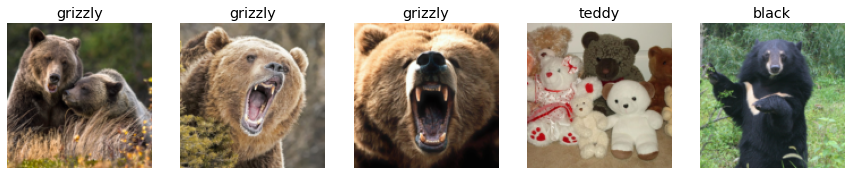

In [20]:
dls.valid.show_batch(max_n=5, nrows=1)

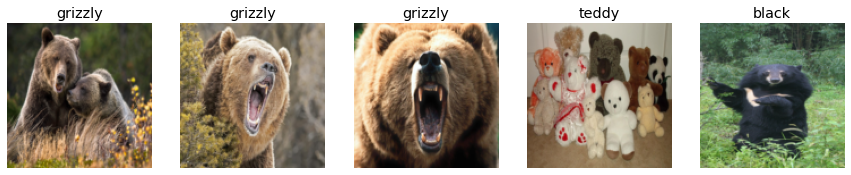

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

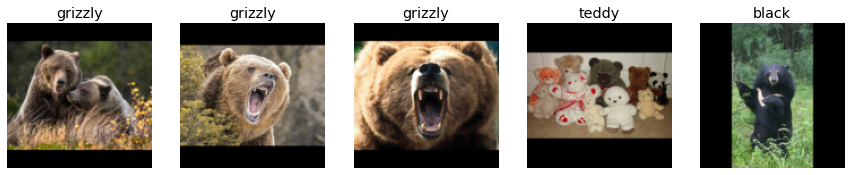

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=5, nrows=1)

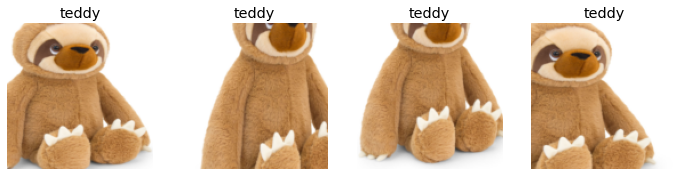

In [23]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

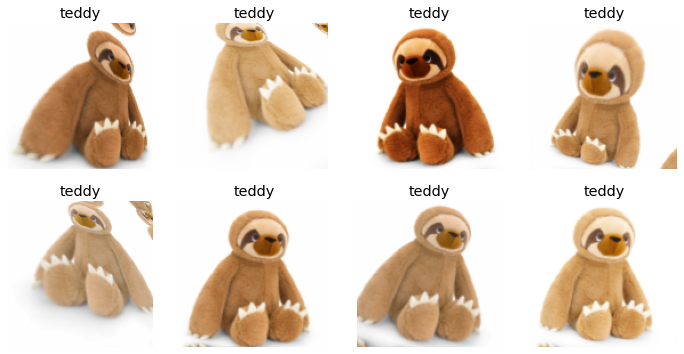

In [24]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [26]:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [27]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.476108,0.182230,0.068182,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.314731,0.073322,0.045455,00:08
1,0.237722,0.008473,0.000000,00:07
2,0.181825,0.005872,0.000000,00:08
3,0.166487,0.007368,0.000000,00:07


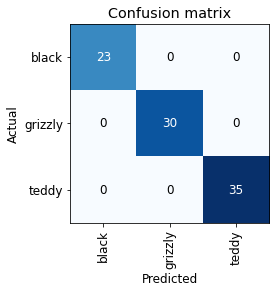

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

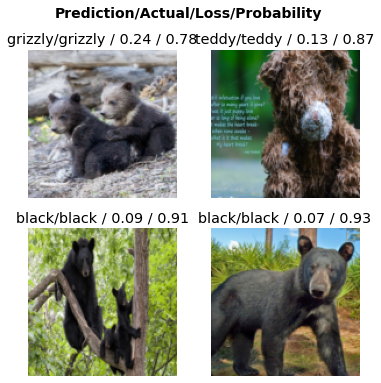

In [29]:
interp.plot_top_losses(4, nrows=2)

In [30]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [32]:
learn.export()

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [35]:
learn_inf = load_learner(path/'export.pkl')

In [36]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorImage(1), TensorImage([2.6287e-06, 1.0000e+00, 1.7055e-06]))

In [37]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [38]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [41]:
img = PILImage.create(btn_upload.data[-1])

In [42]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [43]:
pred,pred_idx,probs = learn_inf.predict(img)

In [44]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [45]:
#hide_output
btn_run = widgets.Button(description='Classificação')
btn_run

Button(description='Classificação', style=ButtonStyle())

In [46]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [47]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [49]:
#hide_output
VBox([widgets.Label('Selecione seu urso!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 